## Import needed libraries
To make things work ensure that you have this libraries installed.

In [13]:
import os
import numpy as np
import splitfolders
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from string import digits
from imutils import paths
from random import choices
from typing import Tuple, List
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GRU, Dense, Bidirectional, InputLayer, Reshape

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1,l2

# Data
The **Dataset** class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [4]:
class Dataset:

    MAX_IMAGES_PER_GENRE = 5_000
    
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, split_folders: bool = False, image_size: Tuple[int, int] = (224,224), batch_size: int = 8 , cache: bool = True):
        assert sum(ratio) == 1.0

        self.path = path
        self.labels = [name for name in tqdm(os.listdir(self.path)) if os.path.isdir(os.path.join(self.path, name))]
        
        self.cache = cache
        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        assert split == True or split_folders == True or output is not None
        
        if split:
            self.__split()
        elif split_folders:
            self.__split_folder()
            
        self.__generate()
    
    def __split(self):
        tmp_ratio = (1.0 - self.ratio[0])
        val_test_ratio = self.ratio[1] / tmp_ratio
        
        def get_genres(path):
            genres = {}
            for image_path in tqdm(list(paths.list_images(path))):
                genre = os.path.basename(os.path.dirname(image_path))

                if genre not in genres:
                    genres[genre] = []
                
                if len(genres[genre]) >= Dataset.MAX_IMAGES_PER_GENRE:
                    continue
                
                genres[genre].append(image_path)
            
            return genres

        
        def split_genre(genre):
            train, tmp = train_test_split(genre, test_size=tmp_ratio, random_state=42)
            test, val = train_test_split(tmp, test_size=val_test_ratio, random_state=42)
            
            return train, val, test
        
        self.train, self.val, self.test = [], [], []
        genres = get_genres(self.path)
        for genre in genres.values():
            train, val, test = split_genre(genre)
            self.train.extend(train)
            self.val.extend(val)
            self.test.extend(test)
    
        np.random.shuffle(self.train)
        np.random.shuffle(self.val)
        np.random.shuffle(self.test)
    
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def __generate(self):
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        def get_paths(x):
            if isinstance(x, str):
                return paths.list_images(x)
            else:
                return x
        
        train_paths = get_paths(self.train)
        self.train_len = len(train_paths) // self.batch_size
        self.train = tf.data.Dataset.from_tensor_slices(train_paths)
        self.train = (self.train
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.train = self.train.cache()
        
        val_paths = get_paths(self.val)
        self.val_len = len(val_paths) // self.batch_size
        self.val = tf.data.Dataset.from_tensor_slices(val_paths)
        self.val = (self.val
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.val = val.train.cache()
        
        test_paths = get_paths(self.test)
        self.test_len = len(test_paths) // self.batch_size
        self.test = tf.data.Dataset.from_tensor_slices(test_paths)
        self.test = (self.test
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.test = self.test.cache()

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [15]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Resnet18

In [16]:
def conv_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=he_normal())(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, strides=(1, 1), padding=padding, kernel_initializer=he_normal())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def ResNet18(input_shape=(224, 224, 3), num_classes=1000):
    input_tensor = tf.keras.Input(shape=input_shape)

    x = conv_block(input_tensor, 64, (7, 7), strides=(2, 2))
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = identity_block(x, 64, (3, 3))
    x = identity_block(x, 64, (3, 3))

    x = conv_block(x, 128, (3, 3), strides=(2, 2))
    x = identity_block(x, 128, (3, 3))
    x = identity_block(x, 128, (3, 3))

    x = conv_block(x, 256, (3, 3), strides=(2, 2))
    x = identity_block(x, 256, (3, 3))
    x = identity_block(x, 256, (3, 3))

    x = conv_block(x, 512, (3, 3), strides=(2, 2))
    x = identity_block(x, 512, (3, 3))
    x = identity_block(x, 512, (3, 3))

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax', kernel_regularizer = l1(0.05))(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    return model

# GTZAN

# STFT

In [17]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size)
train_stft, val_stft, test_stft = dataset.train, dataset.val, dataset.test

Copying files: 4995 files [00:09, 502.75 files/s]


In [18]:
num_classes = 10

model = ResNet18(input_shape=(224, 224, 3), num_classes=num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

epochs = 30

history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)
#                     callbacks = [early_stopping])

model.summary()


Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 35s 152ms/step - accuracy: 0.3912 - loss: 12.7090 - val_accuracy: 0.1073 - val_loss: 9.3789
Epoch 2/30
  1/109 ━━━━━━━━━━━━━━━━━━━━ 12:35 7s/step - accuracy: 0.5000 - loss: 4.5341

W0000 00:00:1714941193.707547     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.6358 - loss: 3.1379 - val_accuracy: 0.1925 - val_loss: 4.5739
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.7291 - loss: 1.4216 - val_accuracy: 0.3138 - val_loss: 2.7408
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.8006 - loss: 1.2055 - val_accuracy: 0.5077 - val_loss: 2.1472
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.8400 - loss: 1.0488 - val_accuracy: 0.6374 - val_loss: 1.7054
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.8719 - loss: 0.9431 - val_accuracy: 0.5914 - val_loss: 1.7705
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.8972 - loss: 0.8793 - val_accuracy: 0.6388 - val_loss: 1.5852
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9237 - loss: 0.7718 - val_accuracy: 0.3933 - val_loss: 2.7004
Epoch 9/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9333 - loss: 0.7213 - val

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 56, 56,    │          0 │ activation_56[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_57[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ activation_58[0]… │
│                     │ 64)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 56, 56,    │          0 │ add_16[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_59[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_60[0]

 Total params: 42,342,560 (161.52 MB)

 Trainable params: 14,110,986 (53.83 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 28,221,974 (107.66 MB)

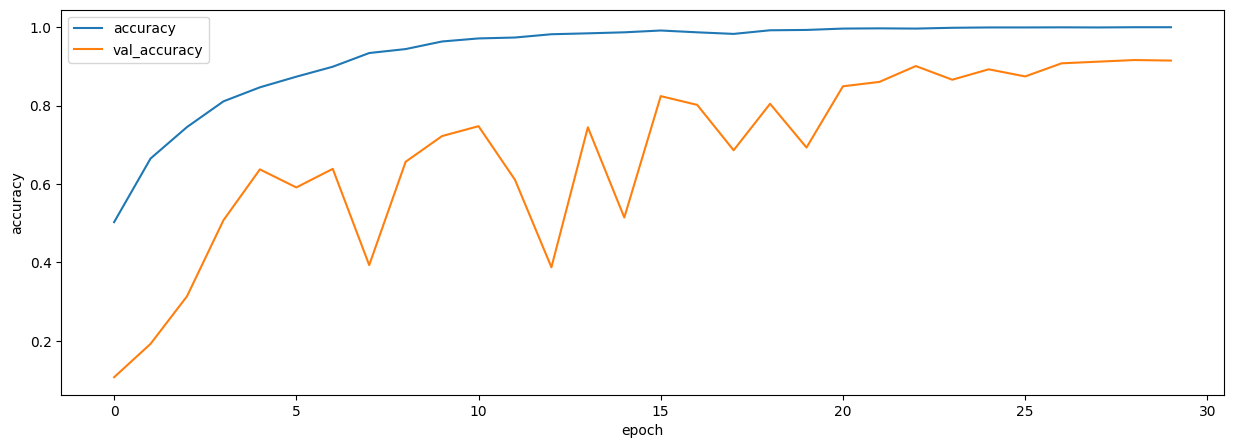

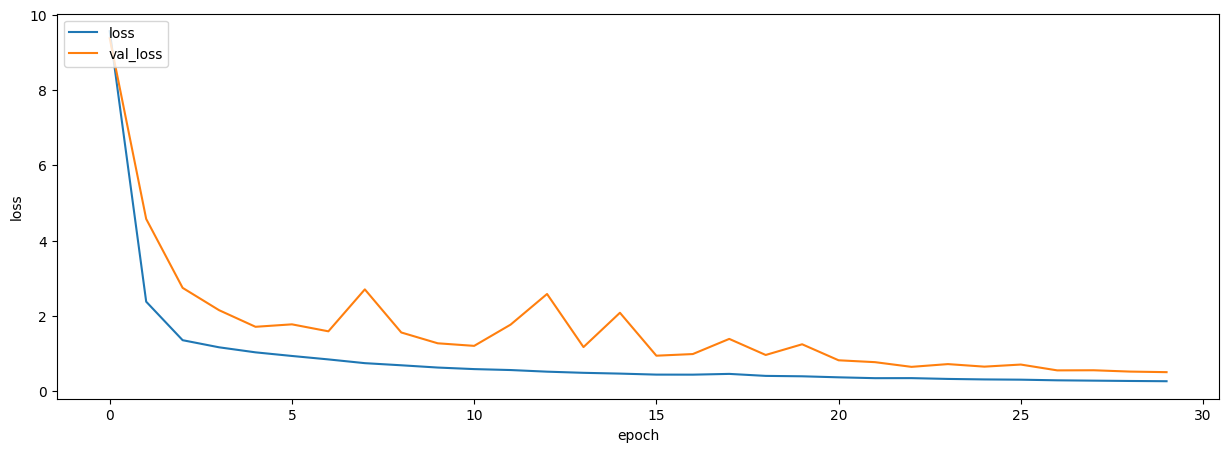

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9391 - loss: 0.4201
Accuracy: 0.9319999814033508
Loss: 0.4536658823490143
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step


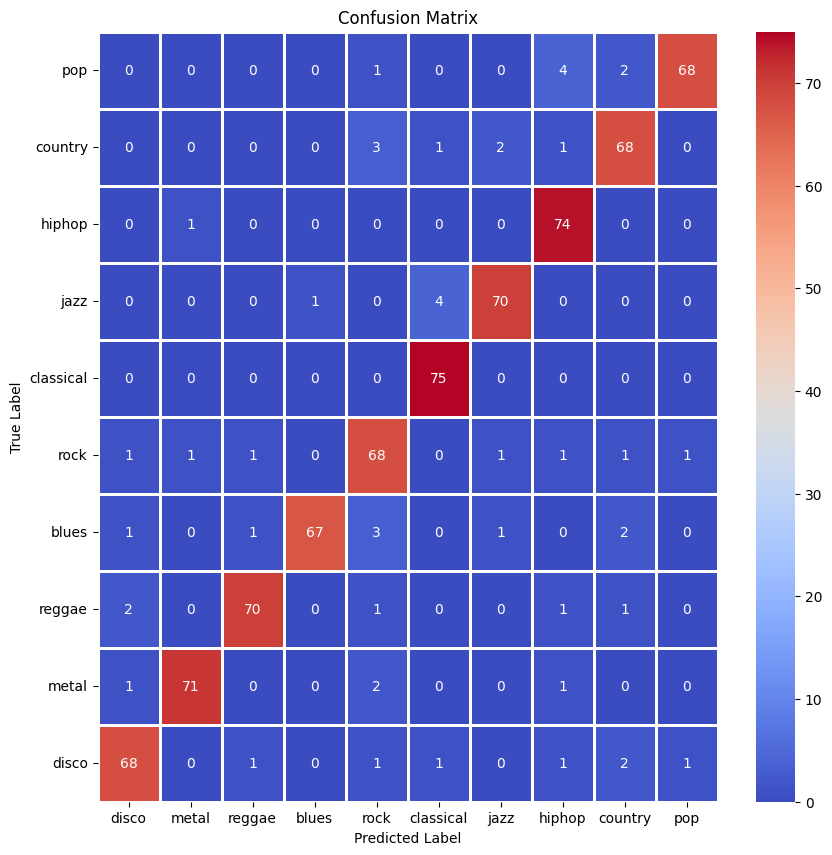

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        75
           1       0.97      0.95      0.96        75
           2       0.96      0.93      0.95        75
           3       0.99      0.89      0.94        75
           4       0.86      0.91      0.88        75
           5       0.93      1.00      0.96        75
           6       0.95      0.93      0.94        75
           7       0.89      0.99      0.94        75
           8       0.89      0.91      0.90        75
           9       0.97      0.91      0.94        75

    accuracy                           0.93       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.93      0.93      0.93       750



In [19]:
plot_history(history, metric="accuracy")
plot_history(history, metric="loss")


evaluation = model.evaluate(test_stft, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')


y_pred = model.predict(test_stft)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_stft], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# Mel - Spectrogram

In [20]:
batch_size = 32
dataset_mel = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size)
train_mel, val_mel, test_mel = dataset_mel.train, dataset_mel.val, dataset_mel.test

Copying files: 4995 files [00:09, 507.73 files/s]


In [21]:
num_classes = 10  

model = ResNet18(input_shape=(224, 224, 3), num_classes=num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

epochs = 30

history = model.fit(dataset_mel.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset_mel.train_len,
                    validation_data=dataset_mel.val,
                    validation_steps=dataset_mel.val_len,
                    verbose=1)
#                     callbacks = [early_stopping])

model.summary()

Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step - accuracy: 0.3450 - loss: 12.8740 - val_accuracy: 0.1318 - val_loss: 8.5025
Epoch 2/30
  1/109 ━━━━━━━━━━━━━━━━━━━━ 12:41 7s/step - accuracy: 0.7500 - loss: 4.2034

W0000 00:00:1714941957.006108     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.5902 - loss: 3.3402 - val_accuracy: 0.2775 - val_loss: 2.6184
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.6436 - loss: 1.6420 - val_accuracy: 0.3529 - val_loss: 2.3989
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7153 - loss: 1.4350 - val_accuracy: 0.3110 - val_loss: 3.1442
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.7482 - loss: 1.3256 - val_accuracy: 0.5356 - val_loss: 2.0901
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.7890 - loss: 1.2023 - val_accuracy: 0.3013 - val_loss: 2.9236
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.8170 - loss: 1.1080 - val_accuracy: 0.4100 - val_loss: 2.2889
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.8301 - loss: 1.0343 - val_accuracy: 0.5579 - val_loss: 2.1025
Epoch 9/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.8621 - loss: 0.9172 - val

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_84       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ activation_84[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_85       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_85[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_86       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 56, 56,    │          0 │ activation_86[0]… │
│                     │ 64)               │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_87       │ (None, 56, 56,    │          0 │ add_24[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_87[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_88       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_88[0]

 Total params: 42,342,560 (161.52 MB)

 Trainable params: 14,110,986 (53.83 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 28,221,974 (107.66 MB)

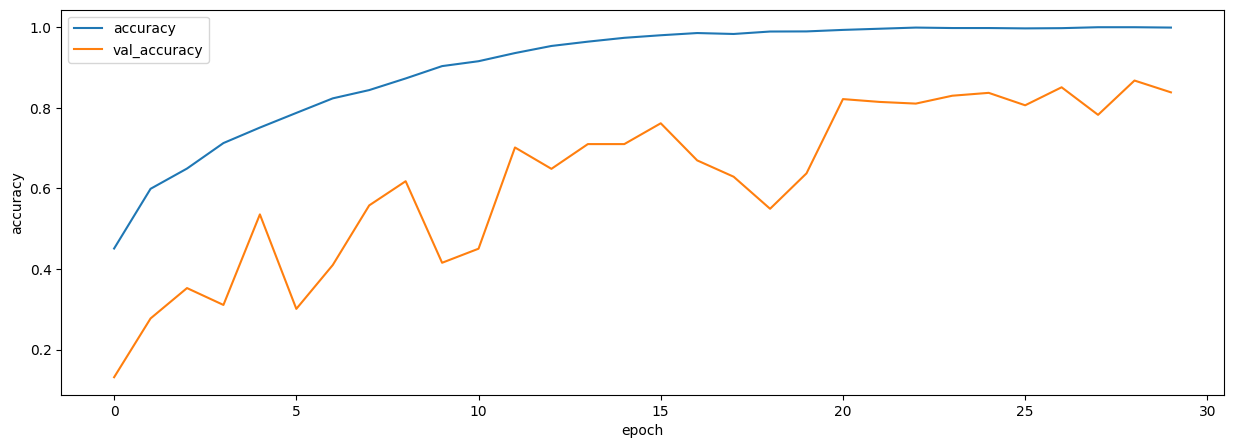

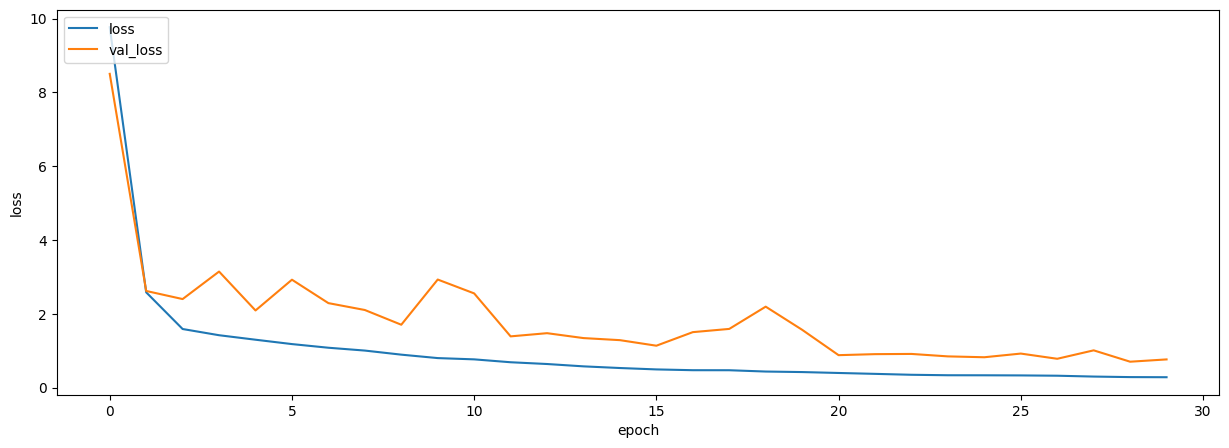

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9098 - loss: 0.5497
Accuracy: 0.8679999709129333
Loss: 0.677699625492096
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


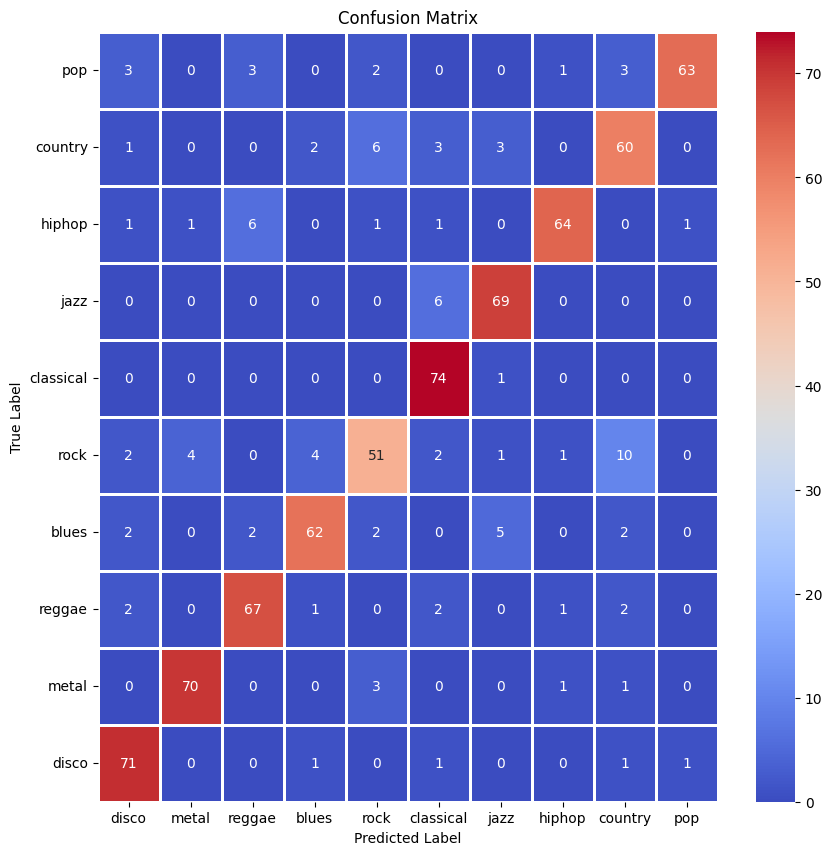

              precision    recall  f1-score   support

           0       0.87      0.95      0.90        75
           1       0.93      0.93      0.93        75
           2       0.86      0.89      0.88        75
           3       0.89      0.83      0.86        75
           4       0.78      0.68      0.73        75
           5       0.83      0.99      0.90        75
           6       0.87      0.92      0.90        75
           7       0.94      0.85      0.90        75
           8       0.76      0.80      0.78        75
           9       0.97      0.84      0.90        75

    accuracy                           0.87       750
   macro avg       0.87      0.87      0.87       750
weighted avg       0.87      0.87      0.87       750



In [22]:
plot_history(history, metric="accuracy")
plot_history(history, metric="loss")


evaluation = model.evaluate(test_mel, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')


y_pred = model.predict(test_mel)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_mel], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# FMA

## STFT

In [7]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/fma-images/stft/stft', batch_size=batch_size, cache=False)

100%|██████████| 64846/64846 [00:00<00:00, 267525.26it/s]


In [8]:
num_classes = 15 

model = ResNet18(input_shape=(224, 224, 3), num_classes=num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

epochs = 30

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

model.summary()

Epoch 1/30
   1/1125 ━━━━━━━━━━━━━━━━━━━━ 9:04:07 29s/step - accuracy: 0.0000e+00 - loss: 25.0840

I0000 00:00:1714904325.983541     134 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714904326.024815     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3888 - loss: 6.2905

W0000 00:00:1714904463.207840     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 192s 145ms/step - accuracy: 0.3889 - loss: 6.2878 - val_accuracy: 0.4435 - val_loss: 2.1477
Epoch 2/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5102 - loss: 1.9950

W0000 00:00:1714904635.590553     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 161s 132ms/step - accuracy: 0.5102 - loss: 1.9949 - val_accuracy: 0.2311 - val_loss: 3.0919
Epoch 3/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 145s 129ms/step - accuracy: 0.5549 - loss: 1.8146 - val_accuracy: 0.4947 - val_loss: 1.9913
Epoch 4/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 145s 129ms/step - accuracy: 0.5963 - loss: 1.6697 - val_accuracy: 0.4327 - val_loss: 2.1288
Epoch 5/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 144s 128ms/step - accuracy: 0.6470 - loss: 1.4889 - val_accuracy: 0.5152 - val_loss: 1.9131
Epoch 6/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 144s 128ms/step - accuracy: 0.7041 - loss: 1.3061 - val_accuracy: 0.6446 - val_loss: 1.4419
Epoch 7/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 142s 127ms/step - accuracy: 0.7515 - loss: 1.1419 - val_accuracy: 0.6648 - val_loss: 1.4224
Epoch 8/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 142s 126ms/step - accuracy: 0.7970 - loss: 0.9936 - val_accuracy: 0.6467 - val_loss: 1.4585
Epoch 9/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 140s 125ms/step - accuracy: 0.8

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ activation_2[0][… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_4[0][

 Total params: 42,350,255 (161.55 MB)

 Trainable params: 14,113,551 (53.84 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 28,227,104 (107.68 MB)

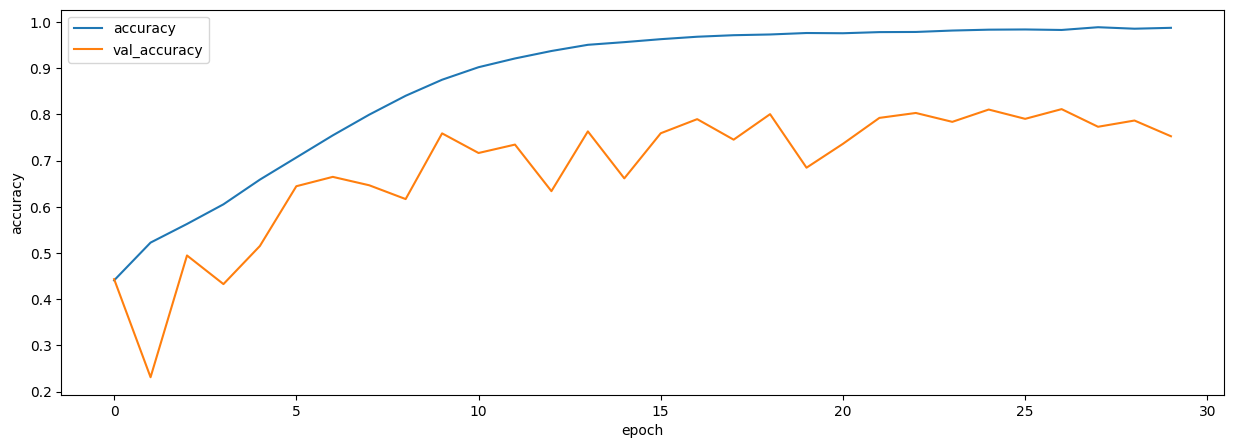

In [9]:
plot_history(history, metric='accuracy')

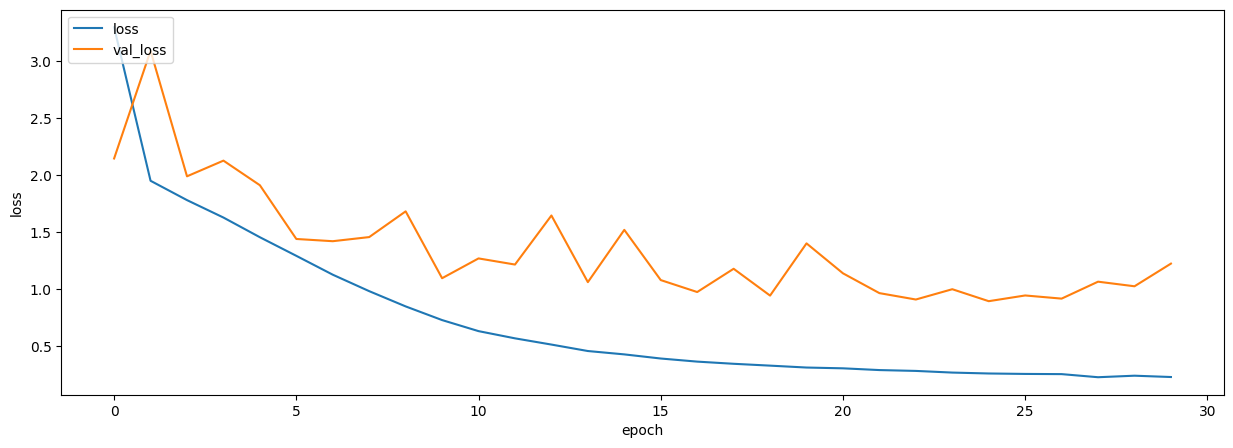

In [10]:
plot_history(history, metric='loss')

In [11]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

242/242 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.7435 - loss: 1.2680
Accuracy: 0.7514570355415344
Loss: 1.2257317304611206


  5/242 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step

W0000 00:00:1714908691.109171     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


242/242 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step


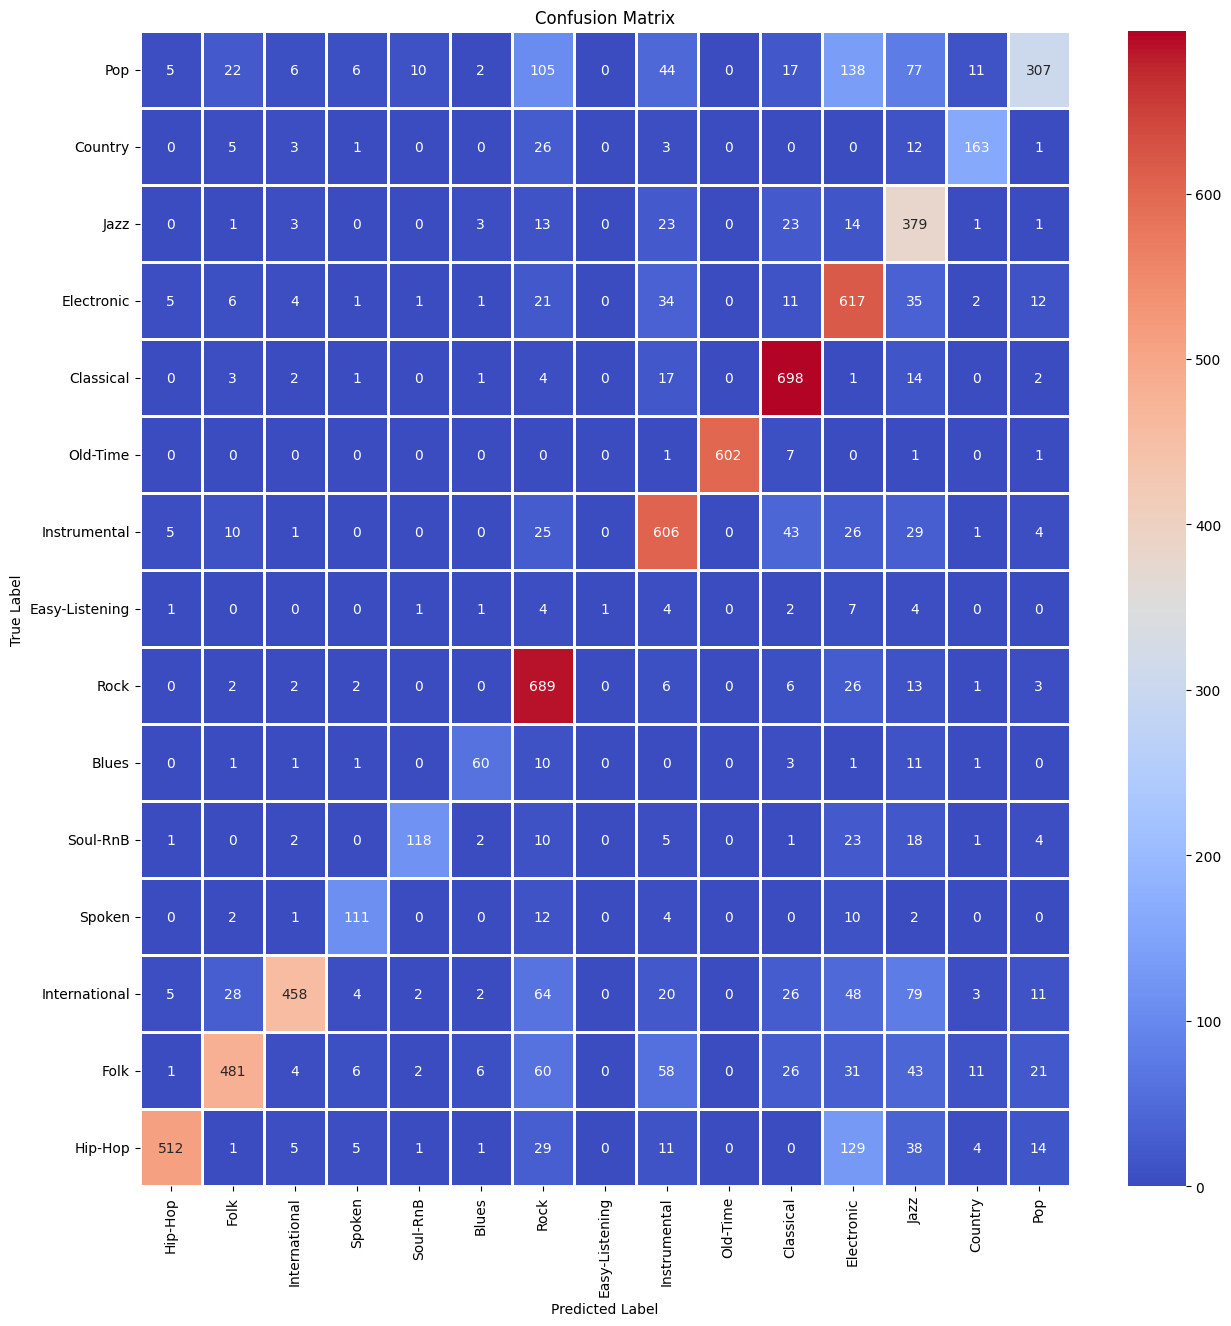

              precision    recall  f1-score   support

           0       0.96      0.68      0.80       750
           1       0.86      0.64      0.73       750
           2       0.93      0.61      0.74       750
           3       0.80      0.78      0.79       142
           4       0.87      0.64      0.74       185
           5       0.76      0.67      0.71        89
           6       0.64      0.92      0.76       750
           7       1.00      0.04      0.08        25
           8       0.72      0.81      0.76       750
           9       1.00      0.98      0.99       612
          10       0.81      0.94      0.87       743
          11       0.58      0.82      0.68       750
          12       0.50      0.82      0.62       461
          13       0.82      0.76      0.79       214
          14       0.81      0.41      0.54       750

    accuracy                           0.75      7721
   macro avg       0.80      0.70      0.71      7721
weighted avg       0.79   

In [12]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

## MEL-SPECTROGRAM

In [6]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/fma-images/mel/mel', batch_size=batch_size, cache=False)

100%|██████████| 64842/64842 [00:00<00:00, 265649.13it/s]


In [9]:
num_classes = 15 

model = ResNet18(input_shape=(224, 224, 3), num_classes=num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

epochs = 30

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

model.summary()

Epoch 1/30
   1/1125 ━━━━━━━━━━━━━━━━━━━━ 9:09:39 29s/step - accuracy: 0.0000e+00 - loss: 23.8884

I0000 00:00:1714910393.818354     134 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714910393.860288     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3913 - loss: 6.1510

W0000 00:00:1714910521.774554     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 179s 133ms/step - accuracy: 0.3914 - loss: 6.1484 - val_accuracy: 0.3361 - val_loss: 2.5518
Epoch 2/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5051 - loss: 2.0094

W0000 00:00:1714910685.895362     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 154s 126ms/step - accuracy: 0.5051 - loss: 2.0094 - val_accuracy: 0.5127 - val_loss: 1.9232
Epoch 3/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 139s 123ms/step - accuracy: 0.5481 - loss: 1.8319 - val_accuracy: 0.4805 - val_loss: 2.0065
Epoch 4/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 138s 123ms/step - accuracy: 0.5812 - loss: 1.6899 - val_accuracy: 0.4647 - val_loss: 2.0171
Epoch 5/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 139s 123ms/step - accuracy: 0.6258 - loss: 1.5464 - val_accuracy: 0.5683 - val_loss: 1.6820
Epoch 6/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 137s 122ms/step - accuracy: 0.6656 - loss: 1.4130 - val_accuracy: 0.5818 - val_loss: 1.6347
Epoch 7/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 137s 121ms/step - accuracy: 0.7100 - loss: 1.2632 - val_accuracy: 0.5924 - val_loss: 1.6209
Epoch 8/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 137s 122ms/step - accuracy: 0.7526 - loss: 1.1252 - val_accuracy: 0.5992 - val_loss: 1.6453
Epoch 9/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 136s 121ms/step - accuracy: 0.7

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ activation_2[0][… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_4[0][

 Total params: 42,350,255 (161.55 MB)

 Trainable params: 14,113,551 (53.84 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 28,227,104 (107.68 MB)

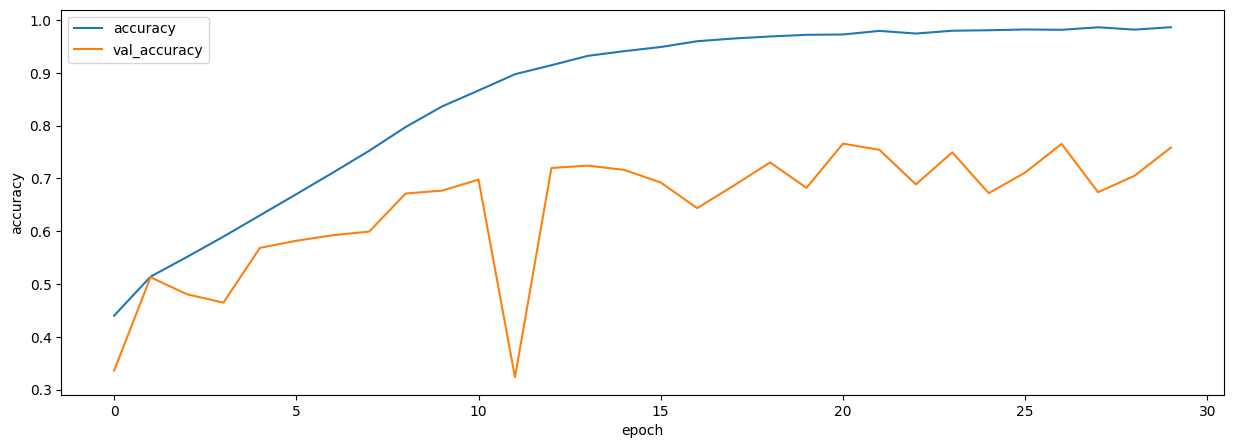

In [10]:
plot_history(history, metric='accuracy')

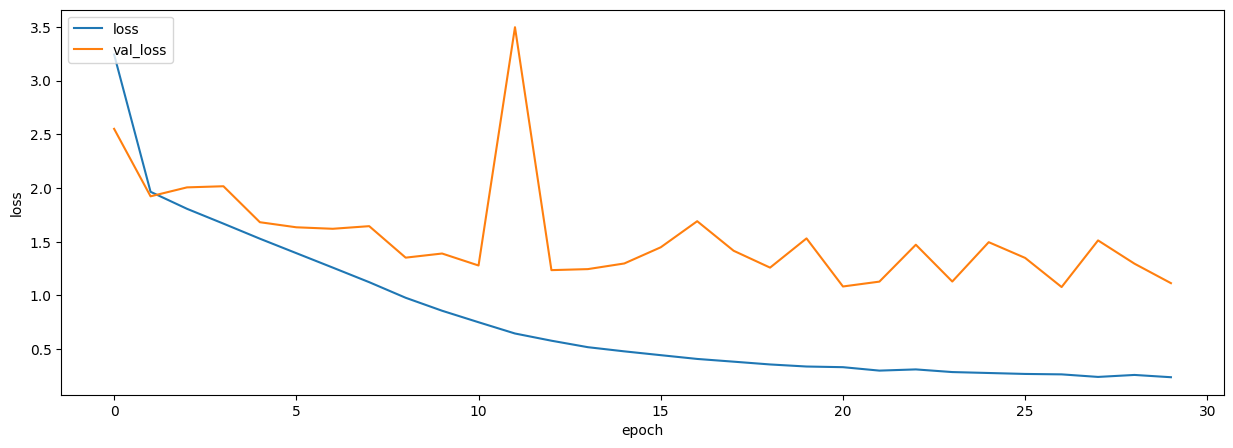

In [11]:
plot_history(history, metric='loss')

In [13]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.7606 - loss: 1.1061
Accuracy: 0.754176914691925
Loss: 1.1348603963851929


  5/242 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step

W0000 00:00:1714914923.625938     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step


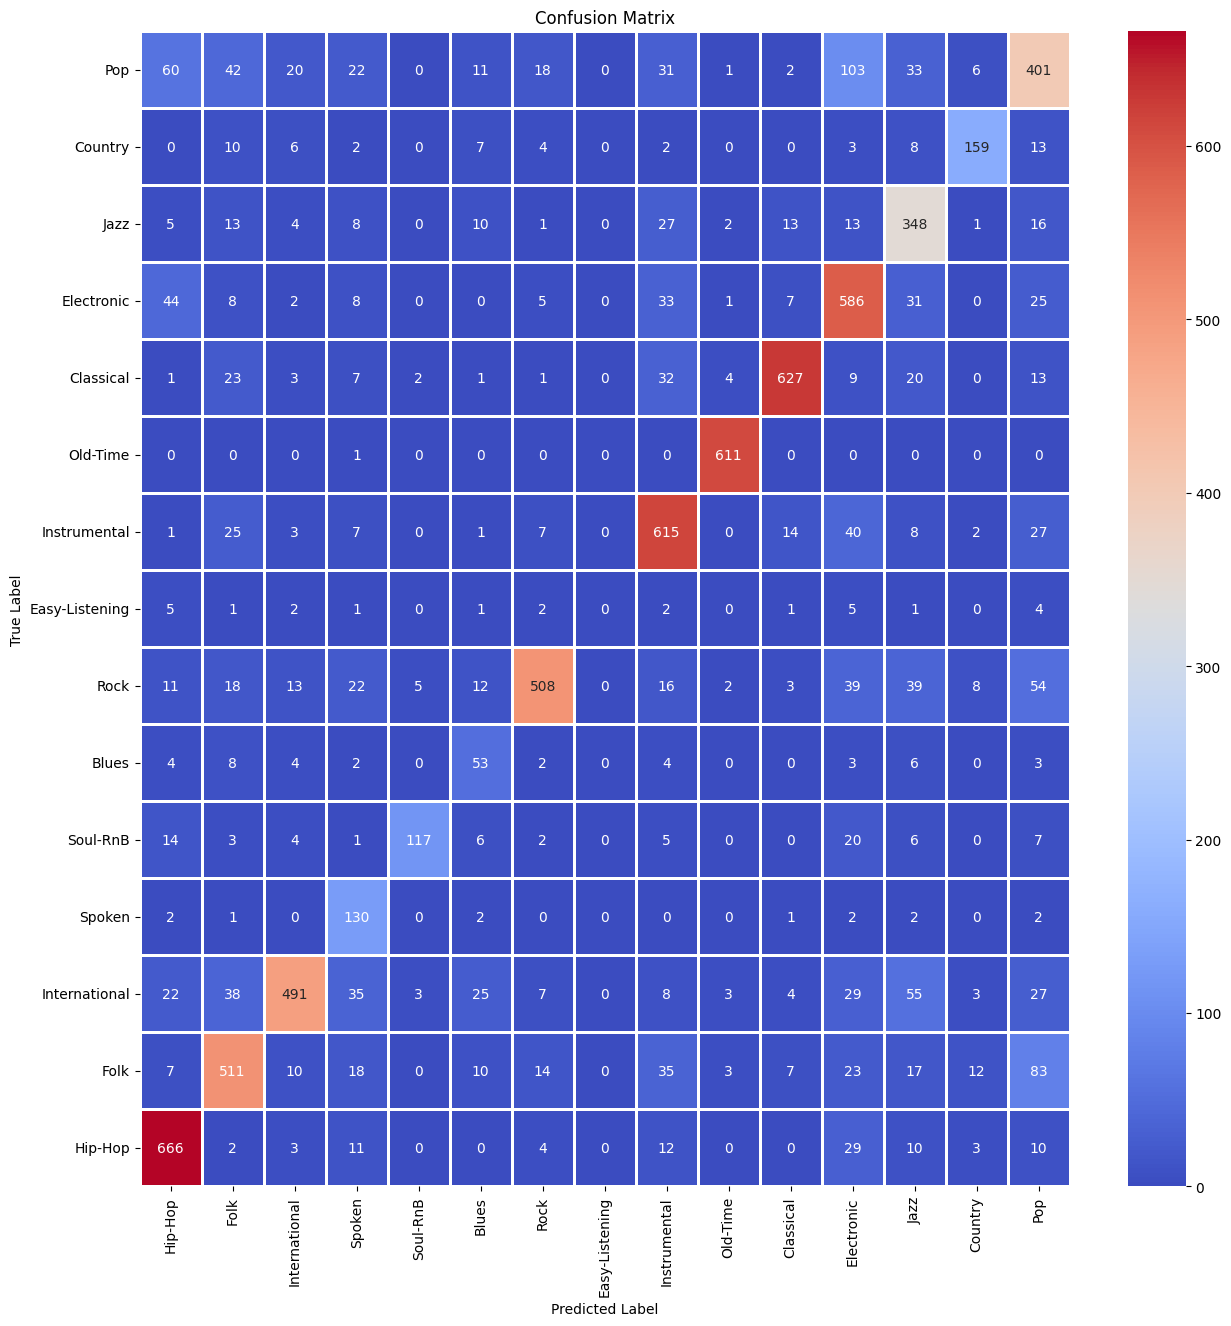

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       750
           1       0.73      0.68      0.70       750
           2       0.87      0.65      0.75       750
           3       0.47      0.92      0.62       142
           4       0.92      0.63      0.75       185
           5       0.38      0.60      0.46        89
           6       0.88      0.68      0.77       750
           7       0.00      0.00      0.00        25
           8       0.75      0.82      0.78       750
           9       0.97      1.00      0.99       612
          10       0.92      0.84      0.88       743
          11       0.65      0.78      0.71       750
          12       0.60      0.75      0.67       461
          13       0.82      0.74      0.78       214
          14       0.59      0.53      0.56       750

    accuracy                           0.75      7721
   macro avg       0.69      0.70      0.68      7721
weighted avg       0.77   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))